In [ ]:
# setup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import sys

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY


In [ ]:
# old function
def split_and_save_data(
    features_path,
    demographics_path,
    id_column="Subject_ID",
    stratify_columns=None,
    use_validation=True,
    test_size=0.1,
    val_size=0.1,
    random_state=42,
    save_path=None
):
    """
    Splits subject IDs into train/val/test sets with optional stratification.
    Saves result as JSON if save_path is given.
    """

    # load data
    features = pd.read_csv(features_path)
    demographics = pd.read_csv(demographics_path)
    df = pd.merge(features[[id_column]], demographics, on=id_column)
    print(f"Merged data shape: {df.shape}")

    # clean stratify columns -> drop rows with missing values in any stratify column
    if stratify_columns:
        for col in stratify_columns:
            df[col] = df[col].astype(str).str.strip().str.lower()
        df = df.dropna(subset=stratify_columns)

        # filter out invalid entries (e.g. 'no_answer' in Country)
        for col in stratify_columns:
            df = df[df[col] != "no_answer"]

        # create stratification group after cleaning and dropping
        df["stratify_group"] = create_stratify_column(df, stratify_columns)
        stratify = df["stratify_group"]
    else:
        stratify = None

    # split test set from everything else
    train_val_ids, test_ids = train_test_split(
        df[id_column],
        test_size=test_size,
        stratify=stratify,
        random_state=random_state
    )

    # create validation set (could be removed later if 80-20 is preferred)
    if use_validation and val_size > 0:
        val_relative_size = val_size / (1 - test_size)
        stratify_val = (
            df[df[id_column].isin(train_val_ids)]["stratify_group"]
            if stratify_columns else None
        )
        train_ids, val_ids = train_test_split(
            train_val_ids,
            test_size=val_relative_size,
            stratify=stratify_val,
            random_state=random_state
        )
    else:
        train_ids = train_val_ids
        val_ids = []

    # summary
    print(f"\nTrain: {len(train_ids)}")
    print(f"Val:   {len(val_ids)}")
    print(f"Test:  {len(test_ids)}")

    # save splits
    splits = {
        "train": sorted(train_ids.tolist()),
        "val": sorted(val_ids.tolist()),
        "test": sorted(test_ids.tolist())
    }

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, "w") as f:
            json.dump(splits, f, indent=4)
        print(f"\nSaved splits to:\n{save_path}")

    return splits


In [ ]:
# old splitting data
import os
import sys

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from data_handling.data_preparation import split_and_save_data

# run the actual split
split_and_save_data(
    features_path=os.path.join(GIT_DIRECTORY, "results/features/filtered/cookieTheft_filtered.csv"),
    demographics_path=os.path.join(GIT_DIRECTORY, "data/demographics_data.csv"),
    stratify_columns=["Country", "Gender"],
    use_validation=True,      # set to false if I want to use 80-20
    test_size=0.1,            # 10% test
    val_size=0.1,             # 10% validation
    save_path=os.path.join(GIT_DIRECTORY, "data", "cookieTheft_splits.json")
)


Split
train    799
val      100
test     100
Name: count, dtype: int64


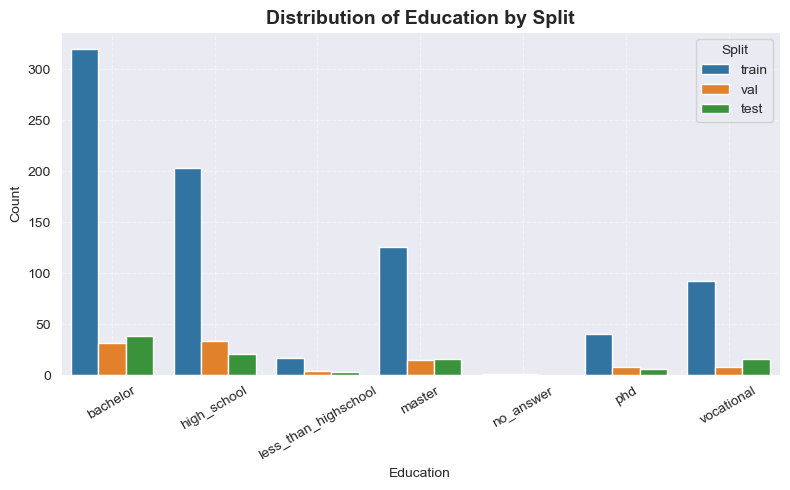

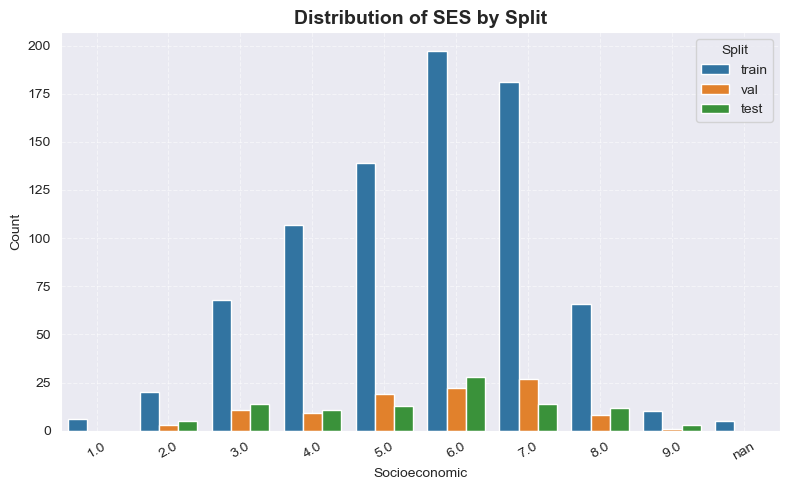

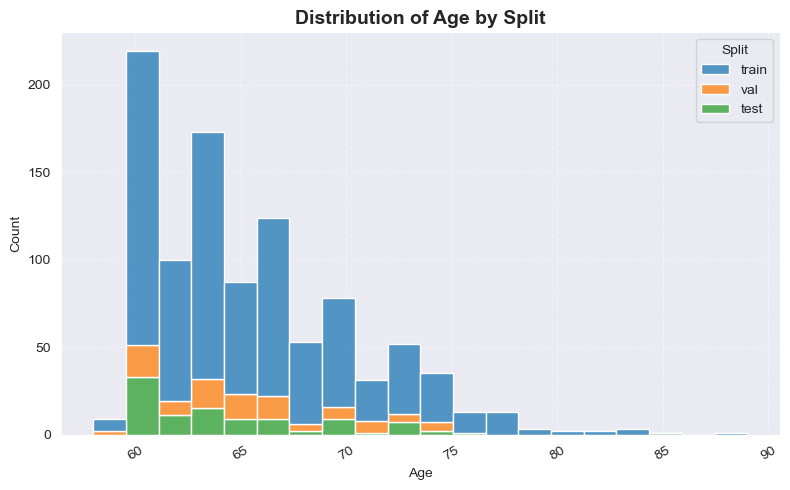

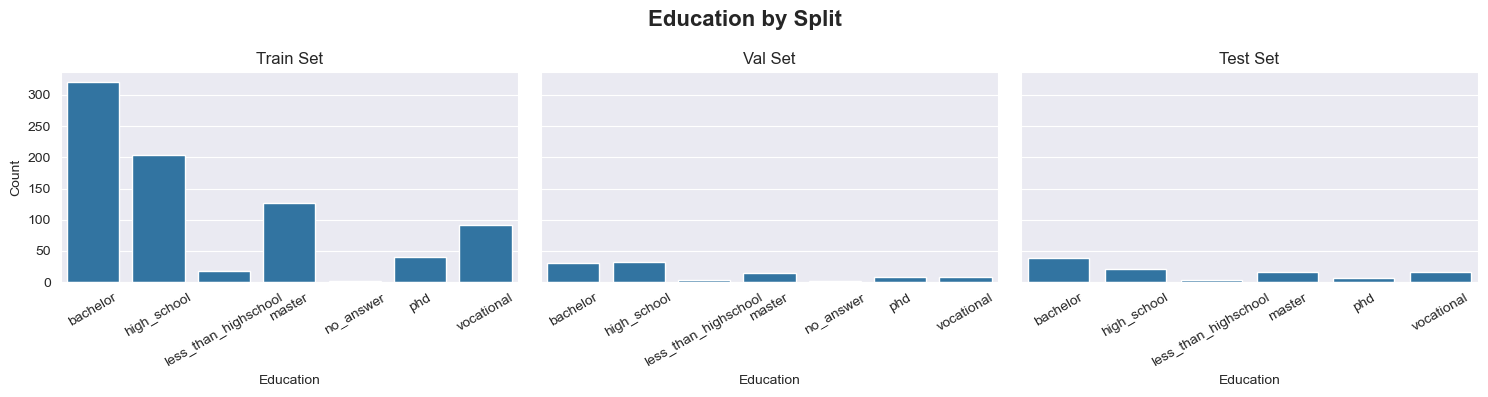

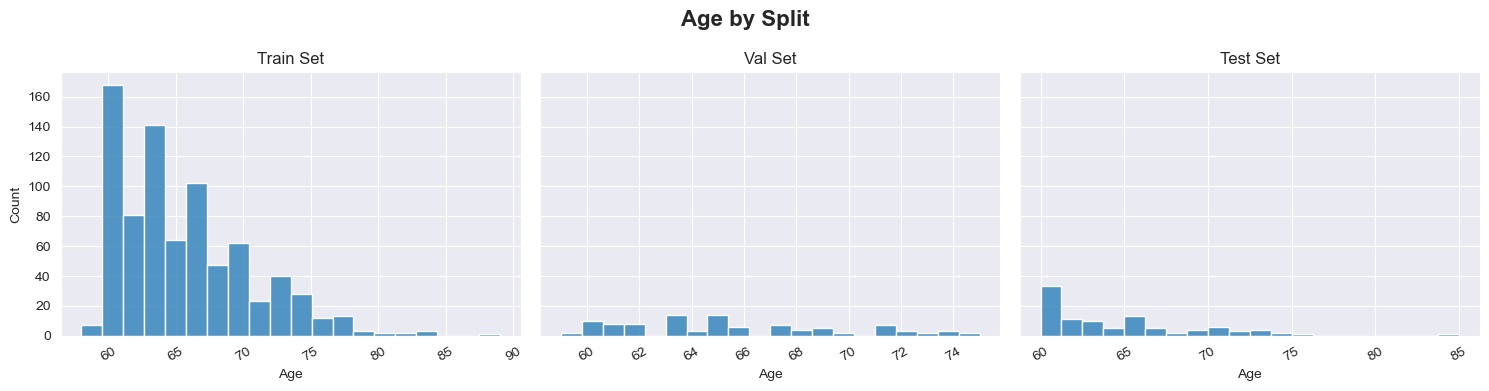

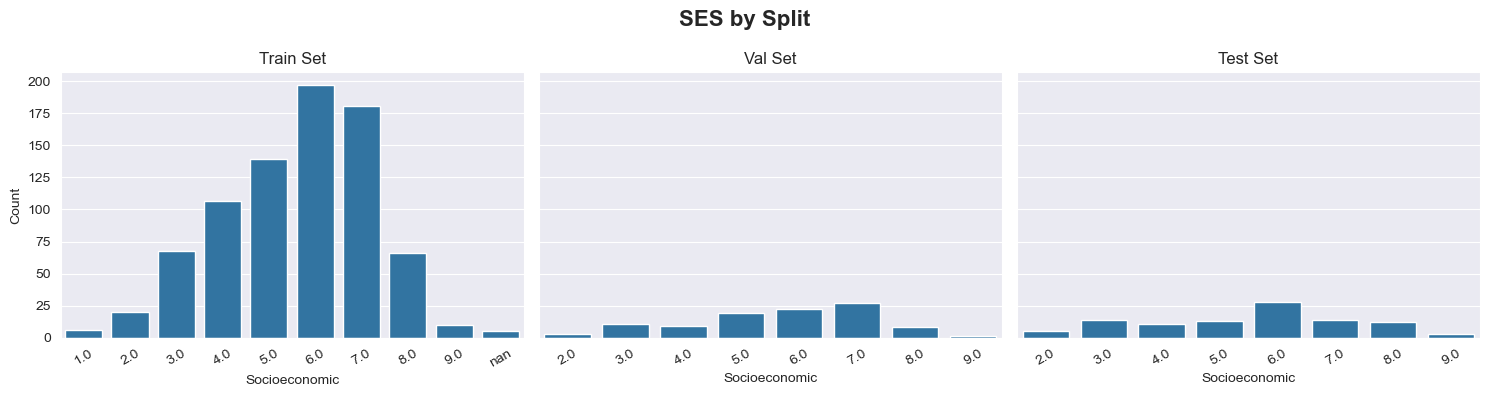

In [1]:


task_name = "cookieTheft"
splits_path = os.path.join(GIT_DIRECTORY, "data", f"{task_name}_splits.json")
demographics_path = os.path.join(GIT_DIRECTORY, "data", "demographics_data.csv")

# load splits
with open(splits_path, "r") as f:
    splits = json.load(f)

# load demographics
df = pd.read_csv(demographics_path)

# add split labels
df["Split"] = df["Subject_ID"].apply(
    lambda x: "train" if x in splits["train"]
    else "val" if x in splits["val"]
    else "test" if x in splits["test"]
    else "excluded"
)

# keep only people in a split
df = df[df["Split"] != "excluded"]
print(df["Split"].value_counts())

# clean optional columns
df["Education"] = df["Education"].astype(str).str.strip().str.lower()
df["Socioeconomic"] = df["Socioeconomic"].astype(str).str.strip().str.lower()

# plot function (all data)
def plot_distribution(col_name, title, continuous=False, save_path=None):
    plt.figure(figsize=(8, 5))

    if continuous:
        # create plot objects to manually force legend labels
        ax = sns.histplot(
            data=df,
            x=col_name,
            hue="Split",
            hue_order=["train", "val", "test"],
            multiple="stack",
            bins=20,
            edgecolor=None
        )

        # manually add legend
        handles, labels = ax.get_legend_handles_labels()
        if handles and labels:
            plt.legend(handles=handles, labels=labels, title="Split")
    else:
        order = sorted(df[col_name].dropna().unique())
        sns.countplot(data=df, x=col_name, hue="Split", order=order)
        plt.legend(title="Split")

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# plot function (splitwise)
def plot_splitwise_distribution(col_name, title, continuous=False, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for ax, split in zip(axes, ["train", "val", "test"]):
        subset = df[df["Split"] == split]
        if continuous:
            sns.histplot(subset[col_name].dropna(), bins=20, ax=ax)
        else:
            order = sorted(subset[col_name].dropna().unique())
            sns.countplot(data=subset, x=col_name, order=order, ax=ax)
        ax.set_title(f"{split.title()} Set")
        ax.set_xlabel(col_name)
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=30)
    plt.suptitle(title, fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()


# plots
plot_distribution("Education", "Distribution of Education by Split")
plot_distribution("Socioeconomic", "Distribution of SES by Split")
plot_distribution("Age", "Distribution of Age by Split", continuous=True)

plot_splitwise_distribution("Education", "Education by Split")
plot_splitwise_distribution("Age", "Age by Split", continuous=True)
plot_splitwise_distribution("Socioeconomic", "SES by Split")